<h1><center>Reinforcement Learning with Function Approximation</center></h1>
<h2><center>Homework 3</center></h2>
<h3><center>Lecturers : Matteo Pirotta & Alessandro Lazaric </center></h3>
<h5><center>Mehdi Boubnan</center></h5>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from HW3_utils import *

In [3]:
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
mpl.rc('font', size = 15)

# On-Policy Reinforcement Learning with Parametric Policy

## REINFORCE with Gaussian policy model

In this section we'll test the REINFORCE algorithm on the linear-quadratic Gaussian regulation (LQG) problem.

We'll consider these parameters for the problem:
- Gaussian policy $a_t/s_t \sim \mathcal{N(\theta.s_t , \sigma^2)}$ with $\sigma = 0.4$
- Transition model $s_{t+1} \sim \mathcal{N(s_t + a_t, 0)}$
- Reward $r_t = -0.5(s_t^2 + a_t^2)$
- Discount factor : $\gamma=0.9$

The parameters for the REINFORCE algorithm are as follows :
- We will collect **N=50** or **N=100** trajectories per iteration. 
- Each trajectory will have at most **T=100** time steps.
- We'll update the policy parameter **n_itr = 60** times for the constant stepper and **n_itr = 100** times for the Adam optimizer.
- We'll average results of **nb_simu=5** experiments.

### LQG Problem without exploration bonus

We initialize the environment and run the reinforce with two steppers.

In [4]:
env = lqg1d.LQG1D(initial_state_type='random')

#### Using Constant stepper

For the constant stepper, we'll use a learning rate equal to **$2.10^{-5}$**.

##### N=50

In [5]:
Reinforce_cte = REINFORCE(env, sigma_w=0.4, N=50, T=100, n_itr=60, discount=0.9, learning_rate=2e-5, nb_simu=5, stepper_type='Constant')

In [6]:
Reinforce_cte.run()

Running 5 simulations: 100%|██████████| 5/5 [03:26<00:00, 41.34s/it]


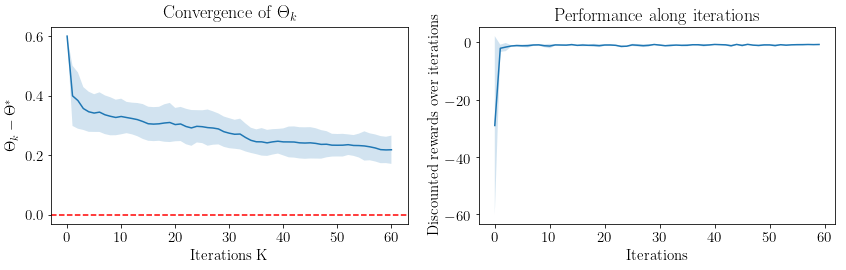

In [7]:
Reinforce_cte.plot_results(theta_true=-0.6, show_std=True)

##### N=100

In [8]:
Reinforce_cte = REINFORCE(env, sigma_w=0.4, N=100, T=100, n_itr=60, discount=0.9, learning_rate=2e-5, nb_simu=5, stepper_type='Constant')

In [9]:
Reinforce_cte.run()

Running 5 simulations: 100%|██████████| 5/5 [06:51<00:00, 81.77s/it]


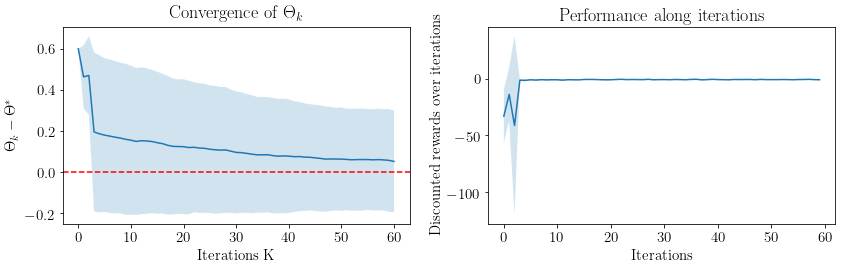

In [10]:
Reinforce_cte.plot_results(theta_true=-0.6, show_std=True)

#### Using Adam stepper

We'll now use the Adam stepper, with $\alpha = 0.2$, and the other parameters as default.

##### N=50

In [11]:
Reinforce_adam = REINFORCE(env, sigma_w=0.4, N=50, T=100, n_itr=100, discount=0.9, learning_rate=0.2, nb_simu=5, stepper_type='Adam')

In [12]:
Reinforce_adam.run()

Running 5 simulations: 100%|██████████| 5/5 [05:41<00:00, 67.79s/it]


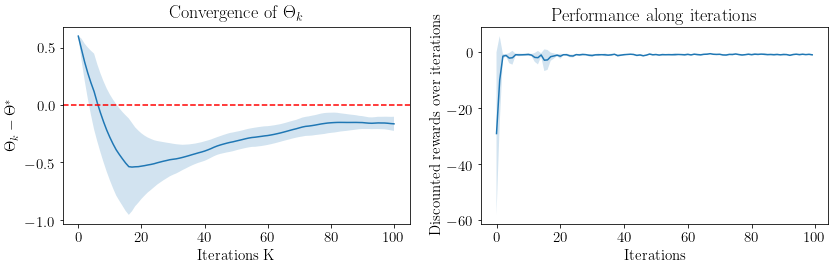

In [13]:
Reinforce_adam.plot_results(theta_true=-0.6, show_std=True)

##### N=100

In [14]:
Reinforce_adam = REINFORCE(env, sigma_w=0.4, N=100, T=100, n_itr=100, discount=0.9, learning_rate=0.2, nb_simu=5, stepper_type='Adam')

In [15]:
Reinforce_adam.run()

Running 5 simulations: 100%|██████████| 5/5 [11:06<00:00, 133.89s/it]


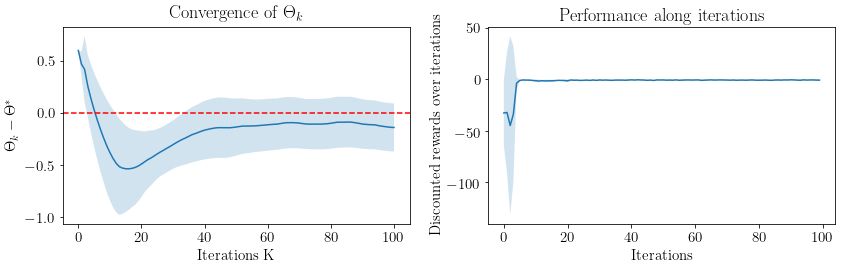

In [16]:
Reinforce_adam.plot_results(theta_true=-0.6, show_std=True)

#### Effect of N

We notice that the variance of the REINFORCE algorithm is very high, as we end with differents results even if we use the same parameters. However, this variance is countered if we increase the number of episodes N. Indeed the variance increase but the convergence is more accurate. Indeed, since we cannot compute the gradient over all the possible trajectories, we estimate the gradient using the Monte-Carlo algorithm over N episode; therefore, if we increase N, the Monte-Carlo estimation is more accurate, and so is the gradient which makes the convergence easier.

#### Effect of $\alpha_t$

For the constant stepper, as the gradients are big (order of $10^5$), we need to take a value for the learning-rate in the same order. Moreover, the more we decrease the learning rate, the slower the algorithm converges. On the other hand, if we increase the learning-rate, we may overshoot the local minima and therefore the algorithm diverges. 

### LQG Problem with exploration bonus

We'll now adopt an optimistic approach called MBIE-BE based on exploration bonus to enforce exploration toward unseen state-action areas.

For that, we'll adopt a new reward : $\tilde{r}(s,a) = r(s,a) + b(s,a)$ with :
$$ b(s,a) = \beta \sqrt{\frac{1}{N_t(\phi(s,a))}} \textrm{ }$$

with $N_t(\phi(s,a))$ number of visits to the bin containing (s,a), and $\phi(s,a)$ a hashing function.

We'll take $\beta = \frac{reward_{max}}{1-\gamma}$ for each trajectory.

We run the algorithm with Adam optimizer with the same parameters as before :

In [17]:
env = lqg1d.LQG1D(initial_state_type='random')

In [18]:
Reinforce_adam = REINFORCE(env, sigma_w=0.4, N=50, T=100, n_itr=100, discount=0.9, learning_rate=0.2, nb_simu=5, stepper_type='Adam')

In [19]:
Reinforce_adam.run(explore_bonus=True)

Running 5 simulations: 100%|██████████| 5/5 [05:55<00:00, 70.85s/it]


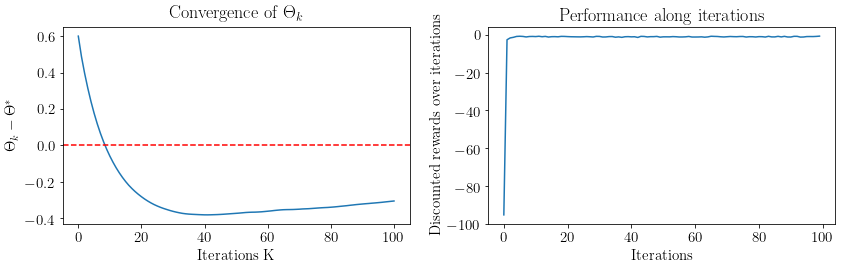

In [20]:
Reinforce_adam.plot_results(theta_true=-0.6, show_std=False)

# Off-Policy Reinforcement Learning with Value Function Approximation

For this section, we'll implement the Linear Fitted Q-iteration. We will approximate the action-value functions by :
$$ \mathcal{F} = \left\{f_{\theta}(s,a) = \theta^{T}\phi(s,a), \theta \in \mathbb{R}^3 \right\} $$
with
$$ \phi(s,a) = (a, sa, s^2 + a^2)^T $$

We take : 
- A discritized state space constitued by 20 points in the interval [-10,10]
- A discritized action space constitued by 20 points in the interval [-8,8]

We initialize the environment, create a dataset of 200 episodes with a horizon equal to 100, and run the Linear Fitted Q-iteration with the following parameters :
- Discount $\gamma = 0.9$
- Ridge regularization coefficient $\lambda = 10^{-3}$

In [21]:
env = lqg1d.LQG1D(initial_state_type='fixed')

actions = np.linspace(-8, 8, 20)
states = np.linspace(-10, 10, 20)

In [22]:
my_FQI=FQI(env, states, actions, discount=0.9, lambd=0.001)
dataset = my_FQI.create_dataset(n_episodes=200, horizon=100)
my_FQI.run_fqi(dataset)

FQI on 200 episodes: 100%|██████████| 200/200 [00:00<00:00, 8582.93it/s]


We plot the Q function estimated by the FQI algorithm and the optimal Q function. The algorithm yields effectively to good results :

Optimal K: [[-0.58840335]] Covariance S: 0.001


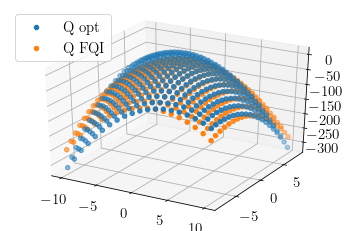

In [23]:
my_FQI.plot_Q()

We finally plot the performance of the algorithm along iterations :

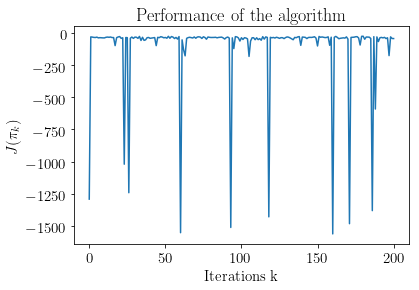

In [24]:
my_FQI.plot_performance()